In [27]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

import itertools
import random

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Load and process metering data (netload forecast)

In [28]:
i = 4
df = pd.read_csv(f"../../archives/LANCEY house data/house{i}.csv", index_col=0, parse_dates=True)

# Drop additionnal information
df.drop(["linky_apparent_power", "linky_tariff_index", "apparent_temperature", "cloud_cover",
         "diffuse_horizontal_irradiance", "direct_normal_irradiance", "humidity", "wind_direction",
         "wind_speed"], axis=1, inplace=True)

# Select a period without missing data (mostly the whole period)
df = df.loc["2022-03-21 23:45:00+00:00":"2022-05-12 23:45:00+00:00", :]

# Fix the few missing data with a linear interpolation
df["global_horizontal_irradiance"] = df["global_horizontal_irradiance"].resample("15T").interpolate()
df["temperature"] = df["temperature"].resample("15T").interpolate()

# Remove the cummulative of metering [Wh] to get incremental energy per timestep [Wh]
df["linky_withdrawal_energy"] = df["linky_withdrawal_energy"].diff()
df["linky_injection_energy"] = df["linky_injection_energy"].diff()
df = df.iloc[1:]

# Blend information into a single vector "netload"
df["netload"] = df["linky_withdrawal_energy"] - df["linky_injection_energy"]
df.drop(["linky_withdrawal_energy", "linky_injection_energy"], axis=1, inplace=True)

# Order, rename, and add units
df = df[["netload", "temperature", "global_horizontal_irradiance"]]
df.columns = ["netload_wh", "temperature_c", "ghi"]

# Turn [Wh] into [kW]
df["netload_kw"] = df["netload_wh"] * 60 / 15 / 1000
df.drop(["netload_wh"], axis=1, inplace=True)

# Arbitrary divide ghi by 100 to be similar to other order of magnitude !!
df["ghi"] /= 100
df.head()

,temperature_c,ghi,netload_kw
2022-03-22 00:00:00+00:00,3.757508,0.0,0.797867
2022-03-22 00:15:00+00:00,3.634630,0.0,1.462667
2022-03-22 00:30:00+00:00,3.532853,0.0,0.860800
2022-03-22 00:45:00+00:00,3.441042,0.0,0.839200
2022-03-22 01:00:00+00:00,3.355804,0.0,0.847467


In [29]:
# Interval of time series (e.g., shift training and prediction)
deltat = timedelta(minutes=15)

# Training end --> prediction start deltat after
end_training = datetime.fromisoformat("2022-04-25 23:45:00+00:00")

# Training start (make sure data available before for lagged values)
training = timedelta(days=31)
start_training = end_training - training

# Duration of one forecast
horizon = timedelta(hours=2, minutes=45)

# Number of forecast
nb_horizon = 16

In [30]:
start_training

datetime.datetime(2022, 3, 25, 23, 45, tzinfo=datetime.timezone.utc)

# Explore data

In [ ]:
fig = px.line(df)

# Red dashed line
fig.add_shape(
 type='line',
 x0=end_training + deltat,
 x1=end_training + deltat, y0=0, y1=20,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=end_training + deltat + nb_horizon * (deltat + horizon),
 x1=end_training + deltat + nb_horizon * (deltat + horizon),
 y0=0, y1=20,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=start_training,
 x1=start_training,
 y0=0, y1=20,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(188, 189, 34, 0.7)'})

fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend={"x": 0.025, "y": 1.1},
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW] & Temp. °C & GHI/100",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0, xaxis_rangeslider_visible=True)
fig.show()

# Timeserie analysis

In [ ]:
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
from plotly.subplots import make_subplots

res = STL(df.netload_kw.values, period=24*4).fit()
def plot_seasonal_decompose(result, dates, title="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            template="plotly_white",
            height=1000, width=1000,
            title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False,
            xaxis_zerolinewidth=2, xaxis_zerolinecolor="black",
            yaxis_zerolinewidth=2, yaxis_zerolinecolor="black",
            xaxis2_zerolinewidth=2, xaxis2_zerolinecolor="black",
            yaxis2_zerolinewidth=2, yaxis2_zerolinecolor="black",
            xaxis3_zerolinewidth=2, xaxis3_zerolinecolor="black",
            yaxis3_zerolinewidth=2, yaxis3_zerolinecolor="black",
            xaxis4_zerolinewidth=2, xaxis4_zerolinecolor="black",
            yaxis4_zerolinewidth=2, yaxis4_zerolinecolor="black",
        )
    )
fig = plot_seasonal_decompose(res, df.index, title="Seasonal Decomposition")
fig.show()

In [ ]:
from statsmodels.tsa.stattools import pacf, acf
import plotly.graph_objects as go

def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series, alpha=0.05, nlags=30*4) if plot_pacf else acf(series, alpha=0.05, nlags=30*4)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(layout, autosize=False, margin_b=50, margin_t=70,
                      width=900, title=title)
    return fig
    
fig = create_corr_plot(df.netload_kw, plot_pacf=False)
fig.show()
fig = create_corr_plot(df.netload_kw, plot_pacf=True)
fig.show()

In [ ]:
fig = create_corr_plot(res.resid, plot_pacf=True)
fig.show()

# GAM (a.k.a. Prophet) model

In [9]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors, 
                 growth,
                 daily_seasonality,
                 weekly_seasonality,
                 yearly_seasonality,
                 seasonality_prior_scale,
                 uncertainty_samples=False,
                 reccord_raw=False):
        
        self._output = output
        self._model = Prophet(
            growth=growth,
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=uncertainty_samples,
        )

        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"], 
                prior_scale=reg["prior_scale"])
        
        self.reccord_raw = reccord_raw
        if self.reccord_raw:
            self.raw = pd.DataFrame()

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        if self.reccord_raw:
            self.raw = pd.concat([self.raw, forecast])
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


https://fr.mathworks.com/help/ident/ref/goodnessoffit.html
NRMSE express between 0% and 100%

$$gof = 1 - \frac{L_2(target_i - pred_i)}{L_2(target_i - mean(target_i))}$$

In [10]:
def get_gof(df, result):
    pred = result.loc[:, ["netload_kw"]].copy()
    if pred.index.tzinfo is None:
        pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], ["netload_kw"]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

# No autoreggressors

In [11]:
def predict_n_periods_T(
    df, start_training, end_training, 
    horizon, deltat, nb_period, regressors=[]):
    
    results = pd.DataFrame()
    inputs = [reg["name"] for reg in regressors]
    model = GAM("netload_kw", regressors,
                growth="linear",
                daily_seasonality="auto",
                weekly_seasonality="auto",
                yearly_seasonality="auto",
                seasonality_prior_scale=10.0,
                uncertainty_samples=False)
    model.fit(df.loc[start_training:end_training])
    start_prediction = end_training
    #print(f"Trained from {start_training.date()} to {end_training}")
    
    for i in range(0, nb_period):
        # Move delta after end last prediction/training
        start_prediction += deltat
        end_prediction = start_prediction + horizon
        
        res = model.predict(df.loc[start_prediction:end_prediction, inputs])
        results = pd.concat([results, res], axis=0)

        #print(f"Predicted from {start_prediction} to {end_prediction.time()}")
        start_prediction = end_prediction
    return results

# With autoreggressors

In [12]:
from tqdm.notebook import tqdm

def lag_values(df, nb_lag):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp["netload_kw"].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(
        df, start_training, end_training, horizon,
        deltat, nb_horizon, regressors, nb_lag,
        daily_seasonality="auto", seasonality_prior_scale=10.0, growth="linear", yearly_seasonality="auto",
        uncertainties=False, disable_progress_bar=False, reccord_raw=False):
    
    results = []
    inputs = [reg["name"] for reg in regressors]
    model = GAM("netload_kw", 
                regressors,
                growth=growth,
                daily_seasonality=daily_seasonality,
                weekly_seasonality="auto",
                yearly_seasonality=yearly_seasonality,
                seasonality_prior_scale=seasonality_prior_scale,
                uncertainty_samples=uncertainties, 
                reccord_raw=reccord_raw)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag)
    model.fit(tmp.loc[start_training:end_training])
    
    start_predictions = [end_training + deltat + i * (horizon + deltat) for i in range(0, nb_horizon)]
    for start_prediction in tqdm(start_predictions, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon
        
        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.loc[step, f"t-{n}"]):
                    tmp.loc[step, f"t-{n}"] = tmp_results[step_i-n]
            
            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, "netload_kw"])
            
        results.append(pd.DataFrame(index=horizon_spam, data={"netload_kw": tmp_results}))
    results = pd.concat(results, axis=0)
    return results, model

# Test three models 
- nothing, 
- ghi regressor, 
- autoregressors + ghi + hours)

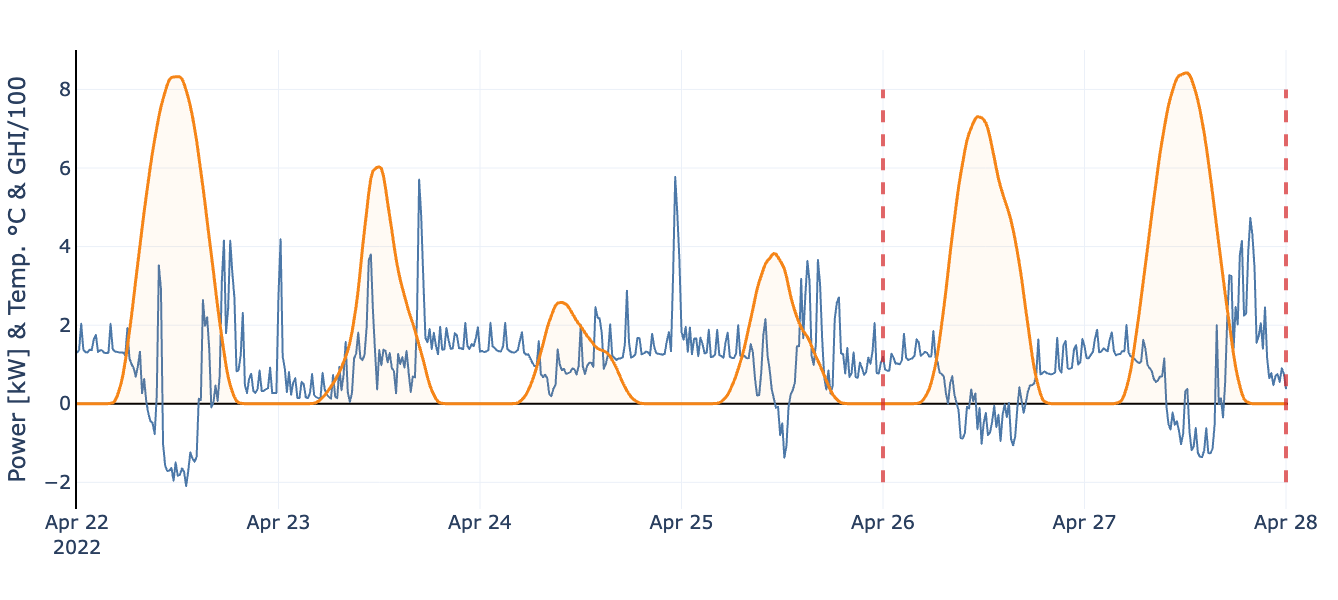

In [33]:
_start = end_training + deltat
_end = _start + nb_horizon * (horizon + deltat)
fig = px.line(df.loc[_start-timedelta(days=4):_end, ["netload_kw", "ghi"]])

fig.data[0].update(line_width=2)
fig.data[-1].update(line_width=3, fill="tozeroy", fillcolor="rgba(255, 127, 14, 0.05)")

# Red dashed line
fig.add_shape(
 type='line',
 x0=end_training + deltat,
 x1=end_training + deltat, y0=-2, y1=8,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=end_training + deltat + nb_horizon * (deltat + horizon),
 x1=end_training + deltat + nb_horizon * (deltat + horizon),
 y0=-2, y1=8,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    height=600,
    width=1000,
    showlegend=False,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW] & Temp. °C & GHI/100",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image("results/maison4.svg")

## No regressors

In [14]:
graph = df.copy()
results = predict_n_periods_T(
    graph, start_training, end_training, horizon, deltat, nb_horizon,
    regressors=[])

gof = get_gof(df, results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


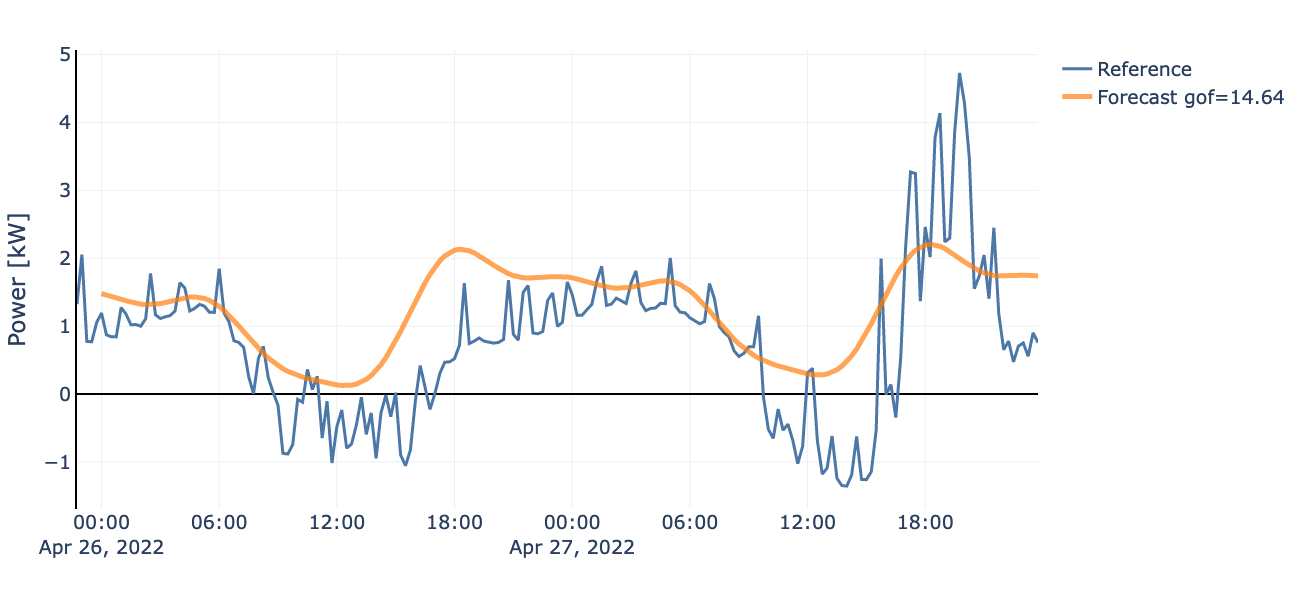

In [15]:
start = end_training
end = start + nb_horizon * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0)

for trace in px.line(results).data:
    fig.add_trace(trace)
    fig.data[-1].update(name=f"Forecast gof={np.round(gof, 2)}",
                        legendgroup=1,
                        line_width=5,
                        line_color="rgba(255, 127, 14, 0.7)")

fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black'
)
fig.show()

## GHI regressor

In [16]:
graph = df.copy()
regressors = [
    #{"name": "temperature_c", "prior_scale": 10.0},
    {"name": "ghi", "prior_scale": 10}]

results = predict_n_periods_T(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors)

gof = get_gof(df, results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


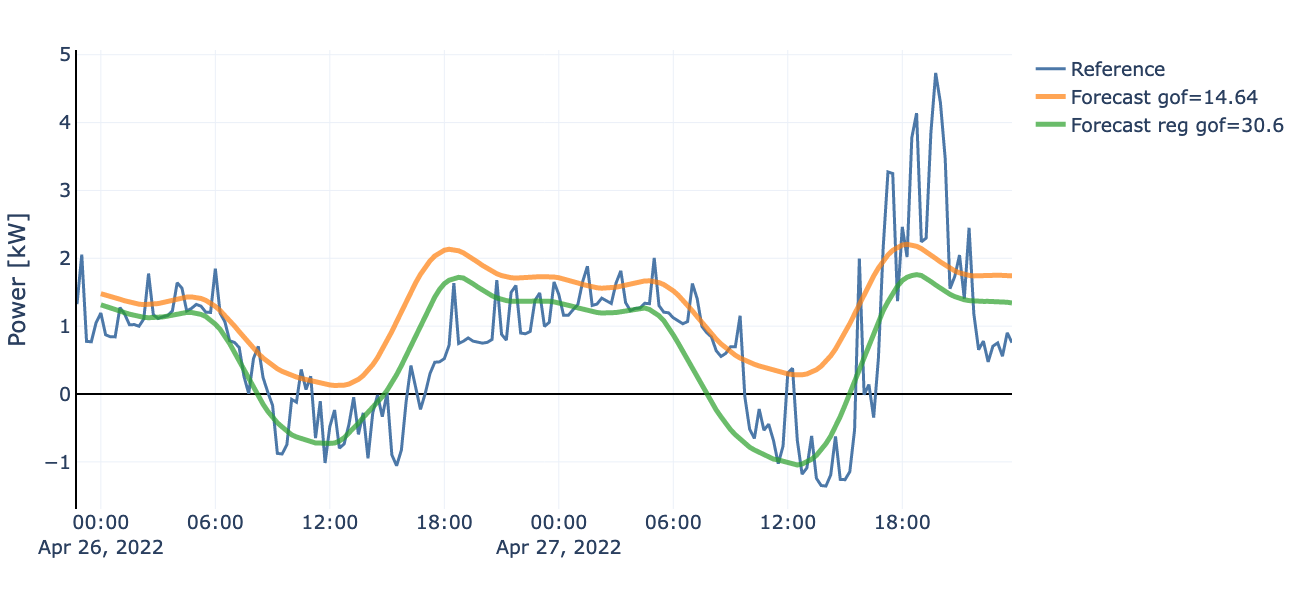

In [17]:
import plotly.graph_objects as go
_fig = go.Figure(fig)


for trace in px.line(results).data:
    _fig.add_trace(trace)
    _fig.data[-1].update(name=f"Forecast reg gof={np.round(gof, 2)}",
                         legendgroup=2,
                         line_width=5,
                         line_color="rgba(44, 160, 44, 0.7)")
_fig.show()

## Auto-regressors

In [18]:
graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": 10.0}]

#graph["_datetime"] = graph.index
#for hour in range(0, 24):
#    graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
#    regressors.append({"name": f"h{hour}", "prior_scale": 10.0})

nb_lag = list(range(1, 4 + 1))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

results, _ = predict_n_periods_with_autoreg(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors, 
    nb_lag=nb_lag)

gof = get_gof(df, results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Forecast:   0%|          | 0/16 [00:00<?, ?it/s]

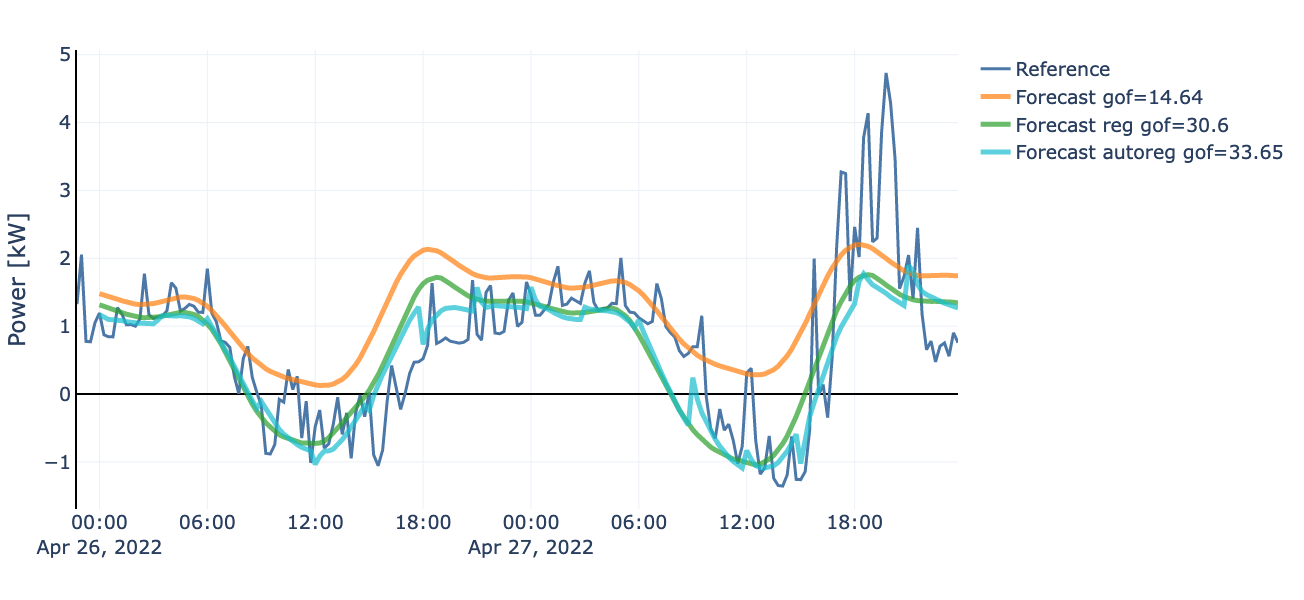

In [19]:
import plotly.graph_objects as go
__fig = go.Figure(_fig)

for trace in px.line(results).data:
    __fig.add_trace(trace)
    __fig.data[-1].update(name=f"Forecast autoreg gof={np.round(gof, 2)}",
                        line_width=5,
                        legendgroup=3,
                        line_color="rgba(23, 190, 207, 0.7)")

__fig.layout.update(xaxis_tickangle=0)
__fig.show()

In [20]:
__fig.write_image("results/forecasts.svg")

# Pushing to 15 min updates

In [42]:
# Duration of one forecast
horizon = timedelta(hours=2, minutes=45)

# Number of forecast
nb_horizon = 16

graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": 10.0}]

#graph["_datetime"] = graph.index
#for hour in range(0, 24):
#    graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
#    regressors.append({"name": f"h{hour}", "prior_scale": 10.0})

nb_lag = list(range(1, 4 + 1))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

results, _ = predict_n_periods_with_autoreg(
    graph, start_training, end_training, timedelta(minutes=15) - deltat, deltat, 192, 
    regressors, 
    nb_lag=nb_lag)

gof = get_gof(df, results)
print(f"GoF = {np.round(gof, 2)}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Forecast:   0%|          | 0/192 [00:00<?, ?it/s]

GoF = 52.35


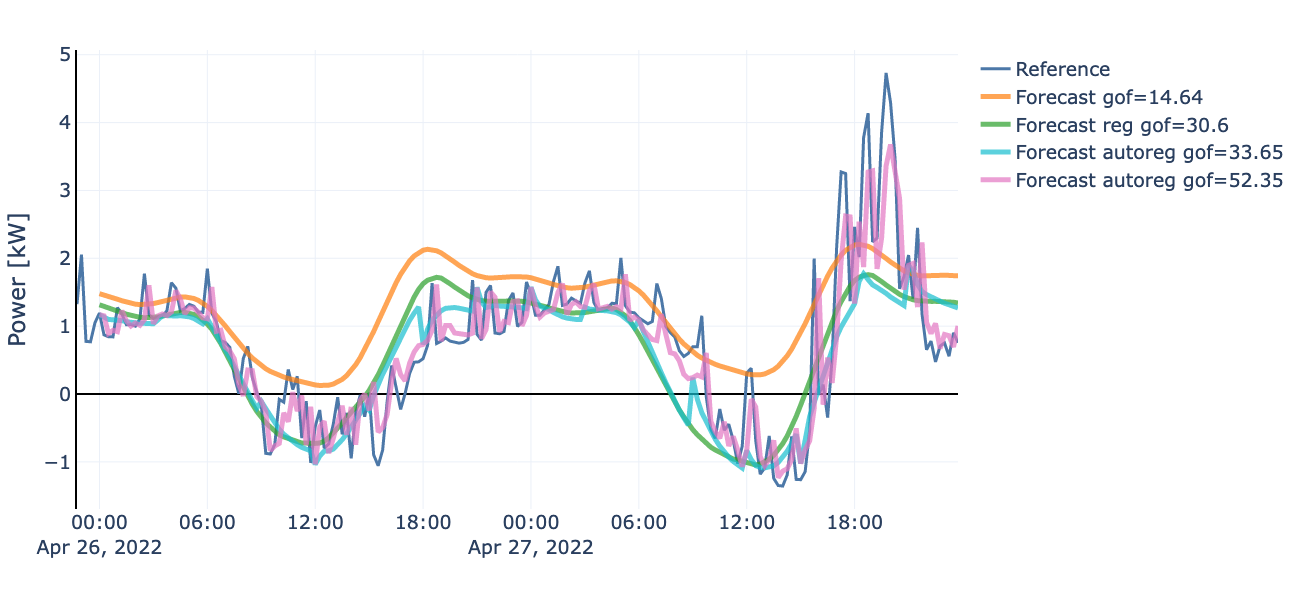

In [43]:
import plotly.graph_objects as go
___fig = go.Figure(__fig)

for trace in px.line(results).data:
    ___fig.add_trace(trace)
    ___fig.data[-1].update(name=f"Forecast autoreg gof={np.round(gof, 2)}",
                        line_width=5,
                        legendgroup=4,
                        line_color="rgba(227, 119, 194, 0.7)")

___fig.layout.update(xaxis_tickangle=0)
___fig.show()

# Calibration procedure for last model

In [21]:
def random_scenarios(n):
    my_dict = {
             "GROWTH":       ["linear"],  # ["linear", "flat"]
             "NB_LAG":       list(range(1, 14 + 1)),
             "PRIOR_GHI":    [1, 3.0, 5, 8, 10, 15, 20],
             "PRIOR_LAG":    [1, 5, 10, 15],
             "PRIOR_HOUR":   [8, 10, 15],
             "PRIOR_SEASON": [3, 10, 8]
        } 

    keys, values = zip(*my_dict.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    scenarios = [dict(random.choice(permutations_dicts)) for _ in range(0, n)]
    return scenarios

def list_scenarios():
    reference = {
         "GROWTH": "linear",
         "NB_LAG": 4,
         "PRIOR_GHI": 10.0,
         "PRIOR_LAG": 10.0,
         "PRIOR_HOUR": 10.0,
         "PRIOR_SEASON": 1.0
    }
    
    scenarios = [reference]
    
    ## Growth ?
    #tmp = dict(reference)
    #tmp["GROWTH"] = "flat"
    #scenarios.append(tmp)
    
    for i in range(1, 14 + 1):  #  range(1, 24 + 1)
        scenarios.append(dict(reference))
        scenarios[-1]["NB_LAG"] = i
    
    for i in [1, 5, 8, 10, 15, 20]:
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_GHI"] = i   
  
    for i in [1, 5, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_LAG"] = i 

    for i in [8, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_HOUR"] = i 

    for i in [3, 8]:  #  [3, 5, 8, 10, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_SEASON"] = i          
    return scenarios    


def calibrate(df, start_training, end_training, horizon, deltat, nb_horizon, scenarios):    
    gofs = []

    # ##### ADD hour regressive variables
    graph = df.copy()
    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)
    # #####
    
    for scenario in tqdm(scenarios, desc="Calibration :"):
        regressors = [{"name": "ghi", "prior_scale": scenario["PRIOR_GHI"]}]
        
        for hour in range(0, 24):
            regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

        nb_lag = list(range(1, scenario["NB_LAG"] + 1))
        for n in nb_lag:
            regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

        results, _ = predict_n_periods_with_autoreg(
            graph, start_training, end_training, horizon, deltat, nb_horizon, 
            regressors, 
            nb_lag=nb_lag,
            growth=scenario["GROWTH"],
            daily_seasonality="auto",
            yearly_seasonality=False,  # Avoid message...
            seasonality_prior_scale=scenario["PRIOR_SEASON"],
            disable_progress_bar=True)

        gofs.append(get_gof(df, results))
    results = pd.DataFrame(data=scenarios)
    results["gof"] = gofs
    return results

In [22]:
#scenarios = list_scenarios()
#_results = calibrate(df, 
#                     start_training, 
#                     datetime.fromisoformat("2022-04-20 23:45:00+00:00"), 
#                     horizon, deltat, 24, scenarios)
#scores = _results.copy()
#scores.drop_duplicates(keep='first', inplace=True)

In [23]:
#scores.nlargest(columns="gof", n=10)

In [26]:
scenarios = random_scenarios(n=50)
scenarios.append({
     "GROWTH": "linear",
     "NB_LAG": 4,
     "PRIOR_GHI": 10,
     "PRIOR_LAG": 10,
     "PRIOR_HOUR": 10,
     "PRIOR_SEASON": 10
    }  
)

_results_random = calibrate(df, 
                     start_training, 
                     end_training,  
                     horizon, deltat, nb_horizon, scenarios)
scores_random = _results_random.copy()
scores_random.drop_duplicates(keep='first', inplace=True)

Calibration ::   0%|          | 0/51 [00:00<?, ?it/s]

In [28]:
scores_random.nlargest(columns="gof", n=10)

,GROWTH,NB_LAG,PRIOR_GHI,PRIOR_LAG,PRIOR_HOUR,PRIOR_SEASON,gof
50,linear,4,10.0,10,10,10,34.011277
38,linear,5,8.0,15,8,8,33.940556
28,linear,5,5.0,10,15,3,33.874411
45,linear,4,15.0,1,8,8,33.822301
49,linear,5,1.0,10,8,10,33.769865
12,linear,6,8.0,10,10,10,33.682553
14,linear,5,10.0,15,15,8,33.672990
11,linear,5,1.0,15,8,3,33.653978
4,linear,6,15.0,1,10,3,33.613951
3,linear,6,20.0,1,8,3,33.497575


### Best model is:

In [29]:
best_scenario = {
     "GROWTH": "linear",
     "NB_LAG": 4,
     "PRIOR_GHI": 10,
     "PRIOR_LAG": 10,
     "PRIOR_HOUR": 10,
     "PRIOR_SEASON": 10   
}

# Last model with best calibration look at uncertainties

In [30]:
graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": best_scenario["PRIOR_GHI"]}]

graph["_datetime"] = graph.index
for hour in range(0, 24):
    graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    regressors.append({"name": f"h{hour}", "prior_scale": best_scenario["PRIOR_HOUR"]})

nb_lag = list(range(1, best_scenario["NB_LAG"] + 1))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": best_scenario["PRIOR_LAG"]})

results, mygam = predict_n_periods_with_autoreg(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors, 
    nb_lag=nb_lag,
    growth=best_scenario["GROWTH"],
    daily_seasonality="auto",
    yearly_seasonality=False,  # Avoid message...
    seasonality_prior_scale=best_scenario["PRIOR_SEASON"],
    uncertainties=1000,
    reccord_raw=True)

gof = get_gof(df, results)
print(f"GoF = {np.round(gof, 2)}")

# Forecast:   0%|          | 0/16 [00:00<?, ?it/s]

GoF = 34.01


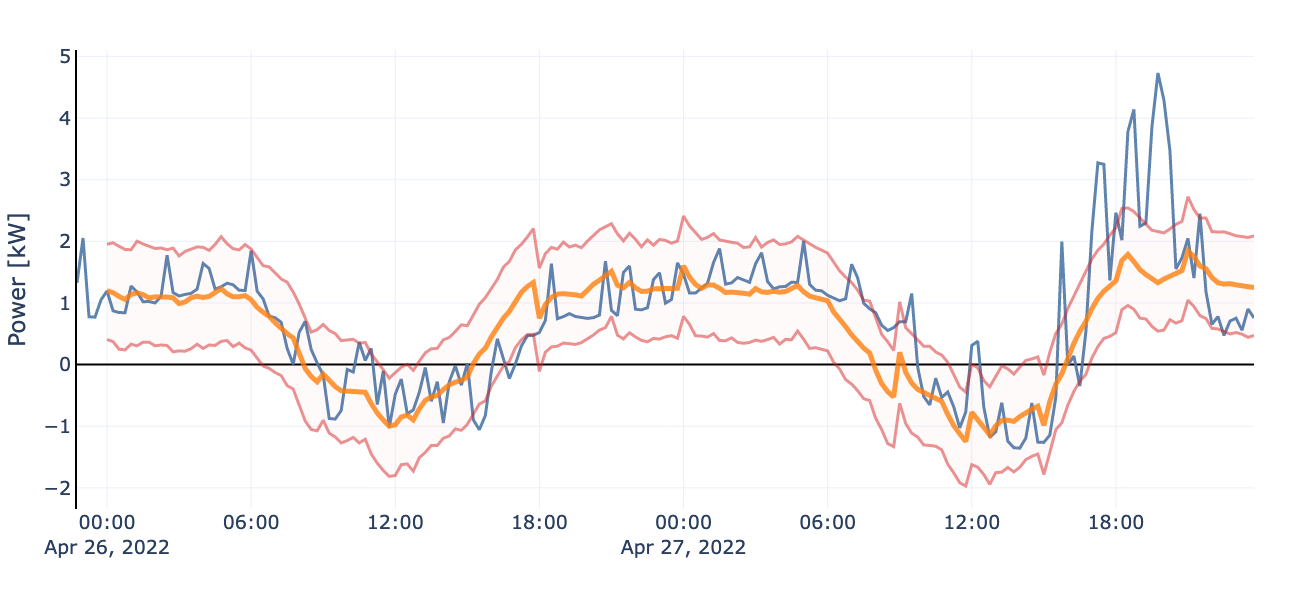

In [31]:
start = end_training
end = start + nb_horizon * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0, opacity=0.9)

graph = mygam.raw.copy()
graph.set_index("ds", inplace=True, drop=True)

colors = ["rgba(214, 39, 40, 0.5)", "rgba(214, 39, 40, 0.5)", "rgba(255, 127, 14, 0.8)"]
sizes = [3, 3, 5]
for i, trace in enumerate(px.line(graph[["yhat_lower", "yhat_upper", "yhat"]]).data):
    fig.add_trace(trace)
    fig.data[-1].update(line_width=sizes[i],
                        line_color=colors[i])

fig.data[-2].update(fill="tonexty", fillcolor="rgba(214, 39, 40, 0.02)")
    
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=False,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0
)
fig.show()

In [32]:
fig.write_image("results/uncertainties.svg")

In [ ]:
#from prophet.plot import plot_components_plotly, plot_components
#fig = plot_components_plotly(mygam._model, mygam.raw)
#fig = plot_components(mygam._model, mygam.raw)